# Introduction to text analytics seminar.

Author: Dr Stef Garasto.

Licence: [GPLv3](https://choosealicense.com/licenses/gpl-3.0/).


Python script to reproduce (approximately and partially) the paper ["Analyzing Gender Bias within Narrative Tropes"](https://aclanthology.org/2020.nlpcss-1.23.pdf) by Gala et al. (2020), part 2.

The goal is to show some useful text analytics techniques in context.

Specifically, here we will see:

- a bit about **approximate** matching of specific keywords in a text (using word embeddings).
- topic modelling using Latent Dirichlet Allocation.

(Some of the initial sections are the same as part 1 because we need to pre-process the data again)

These techniques are applied to try and quantify the **binary** "genderedness" of tropes and topics within those tropes.


In [1]:
import numpy as np
import pandas as pd
import time
import requests
import os
import re
import cleantext
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import spacy


In [2]:
#!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md

     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     --------------------------------------- 0.0/42.8 MB 660.6 kB/s eta 0:01:05
     ---------------------------------------- 0.3/42.8 MB 3.2 MB/s eta 0:00:14
      --------------------------------------- 0.8/42.8 MB 5.9 MB/s eta 0:00:08
     - -------------------------------------- 1.5/42.8 MB 7.5 MB/s eta 0:00:06
     -- ------------------------------------- 2.1/42.8 MB 9.1 MB/s eta 0:00:05
     -- ------------------------------------- 3.1/42.8 MB 10.9 MB/s eta 0:00:04
     --- ------------------------------------ 4.2/42.8 MB 12.6 MB/s eta 0:00:04
     ---- ----------------------------------- 5.2/42.8 MB 13.4 MB/s eta 0:00:03
     ----- ---------------------------------- 6.3/42.8 MB 14.5 MB/s eta 0:00:03
     ------- -------------------------------- 7.6/42.8 MB 16.2 MB/s eta 0:00:03
     -------- ------------------------------- 9.1/42.8 MB 17.6 MB/s eta 0:00:02
     --------- ----------------------------- 10.5/42

## Data loading

In [3]:
url_aug_tropes= 'https://raw.githubusercontent.com/sg4gre/gre_ta_seminar_data/main/TVTropesData/partial_augmented_tropes.csv'


In [4]:
# load tropes and example occurrences in films
try:
    augmented_tropes = pd.read_csv('../gre_ta_seminar_data/TvTropesData/partial_augmented_tropes.csv')
except:
    augmented_tropes = pd.read_csv(url_aug_tropes)


Let's load the list of words that we will use to quantify the perceived and binary genderdeness of tropes.

Source for the lists of words: https://github.com/uclanlp/gn_glove/tree/master/wordlist.


In [5]:
# data loading
with open('male_word_file.txt') as f:
    male_words = f.read()
male_words = male_words.split('\n')
    
print(male_words[:3])

# data loading
with open('female_word_file.txt') as f:
    female_words = f.read()
female_words = female_words.split('\n')
print(female_words[:3])


['countryman', 'fraternal', 'wizards']
['countrywoman', 'sororal', 'witches']


## A quick further look at the word matching

Using Spacy's PhraseMatcher, we matched **exact** occurrences of the "male" and "female" words as they appear in the tropes' descriptions and examples. 

What if there are spelling mistakes? What if we want to also look for **similar** words, without needing to re-do the original list every time.

In short, we might want to do some "fuzzy" (that is, non-exact) matching.

Two possible tools that may help with this are: a) comparing words using the Levenshtein distance and b) comparing words using word embeddings. 

While we won't see the Levensthein distance in this tutorial, briefly this is a tool that allows us to quantify how similar two words are based on the 'minimum number of single-character edits required to change one word into the other'. For example, 'trope' and 'trpe' would have a distance of 1. This can be a good tool to catch spelling mistakes, though be careful: also 'take' and 'bake' have a distance of 1! A good python implementation is the [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/) package.

Let's see what we can do with embeddings.

#### Using embeddings for similarity matching

As mentioned, we can represent words (and text data in general) via embeddings. A word embedding is a representation of a word via a list of numbers, where each vector is computed in a way that attempts to preserve the semantic meaning of each word. These vectors are called dense since most of their entries will not be zero. 

This allows to store information in a more compact manner and therefore reduce the dimensionality of our data. Word embeddings are usually trained on large collections of text, since they have to learn and leverage statistical patterns in text data. A famous word embedding model is ["Word2Vec"](https://arxiv.org/abs/1301.3781) by Mikolov et al.

The good news is that spaCy comes with word embeddings that someone else has already trained! (Although the documentation for how exactly they are trained is sparse). 
That is, Spacy has a mapping from words to pre-made lists of numbers that are meant to encode the semantic meaning of those words (it's not **all** possible words, but it's typically a large enough vocabulary).

With spaCy we can obtain a vector embedding for each of the tokens in the text. spaCy even provides a vector for the whole document which is given by the average vector embedding across all tokens in the document (this strategy often works better for short texts).

We can access the word/document embeddings via the .vector attribute.

Once we have embeddings, we can compute how similar two words are based on how similar their embeddings are. The similarity of two embeddings is computed using a metric called cosine similarity. This is a number between -1 and 1, where:

- -1 suggests two words are "antonyms".
- 0 suggests two words are completely unrelated.
- 1 suggests two words are "synonyms".


##### Implementation note

Lastly, a note about Spacy.

When we call `nlp= spacy.load('en_core_web_md')` (or similar), what we are doing is importing a collection of pre-made algorithms into our python workspaces so that we can apply them to our dataset.

`'en_core_web_sm'`, `'en_core_web_md'` and `'en_core_web_lg'` are three slightly different collections of NLP algorithms, also called NLP pipelines.

'sm' (=small), 'md' (=medium) and 'lg' (=large) refer to the "size" of the algorithms: the bigger the size the more complex the algorithms are. Complexity means that they are more powerul, but also take up more memory and computational resources. The suggestion is to choose the minimal complexity needed to solve your specific problem.

There is an important note to make when using word embeddings. `'en_core_web_sm'` is too small a Spacy pipeline **and does not come with word embeddings**. If you want to use embeddings, you need to choose either `'en_core_web_md'` or `'en_core_web_lg'`. I suggest starting from `'en_core_web_md'`.


In [6]:
# let's load the proper Spacy pipeline (before we use en_core_web_md which does not have a vector per token)
nlp_md = spacy.load("en_core_web_md")

t0= time.time()
# For speed, we will only apply it to the first 20 tropes only
docs_md = list(nlp_md.pipe(augmented_tropes.sort_values(by='GenderedTokensNb',ascending=False)['DescAndExamples'].head(20), 
            ##disabling NLP capabilities that are irrelevant for the task at hand can speed things up
           disable=["ner","parser","textcat"])) 
print(f'Overall it took {(time.time()-t0)/60:.3f} minutes.')



Overall it took 0.316 minutes.


In [7]:
# let's obtain the embedding for each gendered word

# this is how many numbers are in each embedding (the dimension of the embedding)
emb_dim = len(docs_md[0][0].vector)

# "male" words
docs_male = nlp_md.pipe(male_words)
# this create a matrix (a collection of numbers stored as a table) that initially contains all 0s. 
# We create a table with nb of rows = nb of male words and nb of columns = the dimension of the embedding
male_embs = np.zeros((len(male_words), emb_dim)) 
for i,doc in enumerate(docs_male):
    male_embs[i,:] = doc.vector

# same for "female" words
docs_female = nlp_md.pipe(female_words)
female_embs = np.zeros((len(female_words), emb_dim))
for i,doc in enumerate(docs_female):
    female_embs[i,:] = doc.vector


In [8]:

# let's try it on the first trope
# first, we will store an embedding for each token.
doc = docs_md[1]
doc_matrix_embs = np.zeros((len(doc), emb_dim))
for i,token in enumerate(doc):
    doc_matrix_embs[i,:] = token.vector
    
# now compute the cosine similarity between each token and each "male" word
trope_male_similarity = cosine_similarity(doc_matrix_embs,male_embs)

# We define a threshold: two words match if their cosine similarity is more than 0.99.
similarity_threshold = .99
# For each token in a trope, it is a match if it matches at least one of the "male" words with a cosine similarity > 0.99
matched_words = []
for i in range(trope_male_similarity.shape[0]):
    if (trope_male_similarity[i,:]>similarity_threshold).any():
        if doc[i].text not in matched_words:
            print('Matched word:', doc[i].text, f'. Is it in the original list? {doc[i].text in male_words}')
            matched_words.append(doc[i].text)
# example new words matched --> strong, fireman (can be a bit cyclical), but also widow, mother (!).


Matched word: actors . Is it in the original list? True
Matched word: country . Is it in the original list? False
Matched word: fireman . Is it in the original list? False
Matched word: wizard . Is it in the original list? True
Matched word: cameraman . Is it in the original list? True
Matched word: horsemen . Is it in the original list? True
Matched word: man . Is it in the original list? True
Matched word: boy . Is it in the original list? True
Matched word: brother . Is it in the original list? True
Matched word: king . Is it in the original list? True
Matched word: kings . Is it in the original list? True
Matched word: camera . Is it in the original list? False
Matched word: widow . Is it in the original list? False
Matched word: son . Is it in the original list? True
Matched word: strong . Is it in the original list? False
Matched word: prince . Is it in the original list? True


### Exercise

Try and modify the code below so that we explore the word embedding matches for a **different trope**.

For example, instead of using the first trope, what happens if we check the fourth one?

Then/Or, try to decrease the similarity threshold from .99 to .95. Do we get more useful or misleading words?


In [9]:
# let's try it on the fourth trope this time
# first, we will store an embedding for each token.
doc = docs_md[1]
doc_matrix_embs = np.zeros((len(doc), emb_dim))
for i,token in enumerate(doc):
    doc_matrix_embs[i,:] = token.vector
    
# now compute the cosine similarity between each token and each "male" word
trope_male_similarity = cosine_similarity(doc_matrix_embs,male_embs)

# We define a threshold: two words match if their cosine similarity is more than 0.99.
similarity_threshold = .99
# For each token in a trope, it is a match if it matches at least one of the "male" words with a cosine similarity > 0.99
matched_words = []
for i in range(trope_male_similarity.shape[0]):
    if (trope_male_similarity[i,:]>similarity_threshold).any():
        if doc[i].text not in matched_words:
            print('Matched word:', doc[i].text, f'. Is it in the original list? {doc[i].text in male_words}')
            matched_words.append(doc[i].text)



Matched word: actors . Is it in the original list? True
Matched word: country . Is it in the original list? False
Matched word: fireman . Is it in the original list? False
Matched word: wizard . Is it in the original list? True
Matched word: cameraman . Is it in the original list? True
Matched word: horsemen . Is it in the original list? True
Matched word: man . Is it in the original list? True
Matched word: boy . Is it in the original list? True
Matched word: brother . Is it in the original list? True
Matched word: king . Is it in the original list? True
Matched word: kings . Is it in the original list? True
Matched word: camera . Is it in the original list? False
Matched word: widow . Is it in the original list? False
Matched word: son . Is it in the original list? True
Matched word: strong . Is it in the original list? False
Matched word: prince . Is it in the original list? True


# Topic Modelling using Latent Dirichlet Allocation

(Extracted and adapted from: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py (© Copyright 2007 - 2024, scikit-learn developers (BSD License)). Code is provided "as is" (full disclaimer notice at the end). )

Finally, let's see some topic modelling!

Topic modelling is a technique to decompose an entire collection of documents into the topics it is likely to be made of.

Specifically, the idea is that the words in each document are not random, but appear because of the topics that each document is about. We know the words in the document (they are the observed variables), then we want to find N topics (and their associated words) that explain as much of all the documents as possible. Here, topic is intended with a more specific meaning that in it's common usage. Rather than being a concept, or a field, we need to interpret a topic as a collection of words and the strength of association between each topic and those words.

A commonly used technique to find the topics is called Latent Dirichlet Allocation (LDA). LDA (not to be confused with Linear Discriminant Analysis) finds the topics from a collection of documents, each represented using a count-based Bag of Word model.

Training a LDA model means finding the N topics (with N decided by us) that best explain a given collection of documents.

Once we find the topics, we can also find the most important words for each topic (typically used to understand what the topic is about) and the most important topic(s) for each document.

In [10]:


n_samples = 6000
n_features = 500
n_topics = 75
n_top_words = 20

data_filtered = augmented_tropes.sort_values(by='gender_score').copy()
df = pd.concat((data_filtered[:(n_samples//2)],data_filtered[-(n_samples//2):]))


# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(df['DescAndExamples'])

print(
    "\n" * 2,
    f"Fitting LDA models with tf features, n_samples={n_samples} and n_features={n_features}..."
)
# create the (untrained) model.
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=5,
    random_state=0,
)
# train LDA on our tropes.
t0 = time.time()
lda.fit(tf)
print(f"done in {(time.time()-t0):.3f} seconds.")



Extracting tf features for LDA...


 Fitting LDA models with tf features, n_samples=6000 and n_features=500...
done in 38.698 seconds.


In [11]:
# let's get the 20 top words for each topic
n_top_words = 20
tf_feature_names = tf_vectorizer.get_feature_names_out()

top_words_cols = [f'top_word_{i}' for i in range(20)]
top_weights_cols = [f'weight_word_{i}' for i in range(20)]

for topic_idx, topic in enumerate(lda.components_):
    if topic_idx==0:
        topic_df = pd.DataFrame(columns = top_words_cols + top_weights_cols) # we'll store all the information here
    
    # get the indices corresponding to the top words
    top_features_ind = topic.argsort()[-n_top_words:]
    # link those indices to the top words
    top_features = tf_feature_names[top_features_ind]
    # get the weight of how important each word is for the topic
    weights = topic[top_features_ind]
    #topic_df_[top_words_cols]= top_features
    #topic_df_[top_weights_cols]= weights
    # with each new topic we create a new row for the dataframe which we will then append to the main one
    topic_df_ = pd.DataFrame(index= top_words_cols + top_weights_cols, 
                             data = list(top_features) + list(weights))
    #print(topic_df_.T.columns)
    topic_df = pd.concat((topic_df, topic_df_.T))

topic_df = topic_df.reset_index(drop=True)

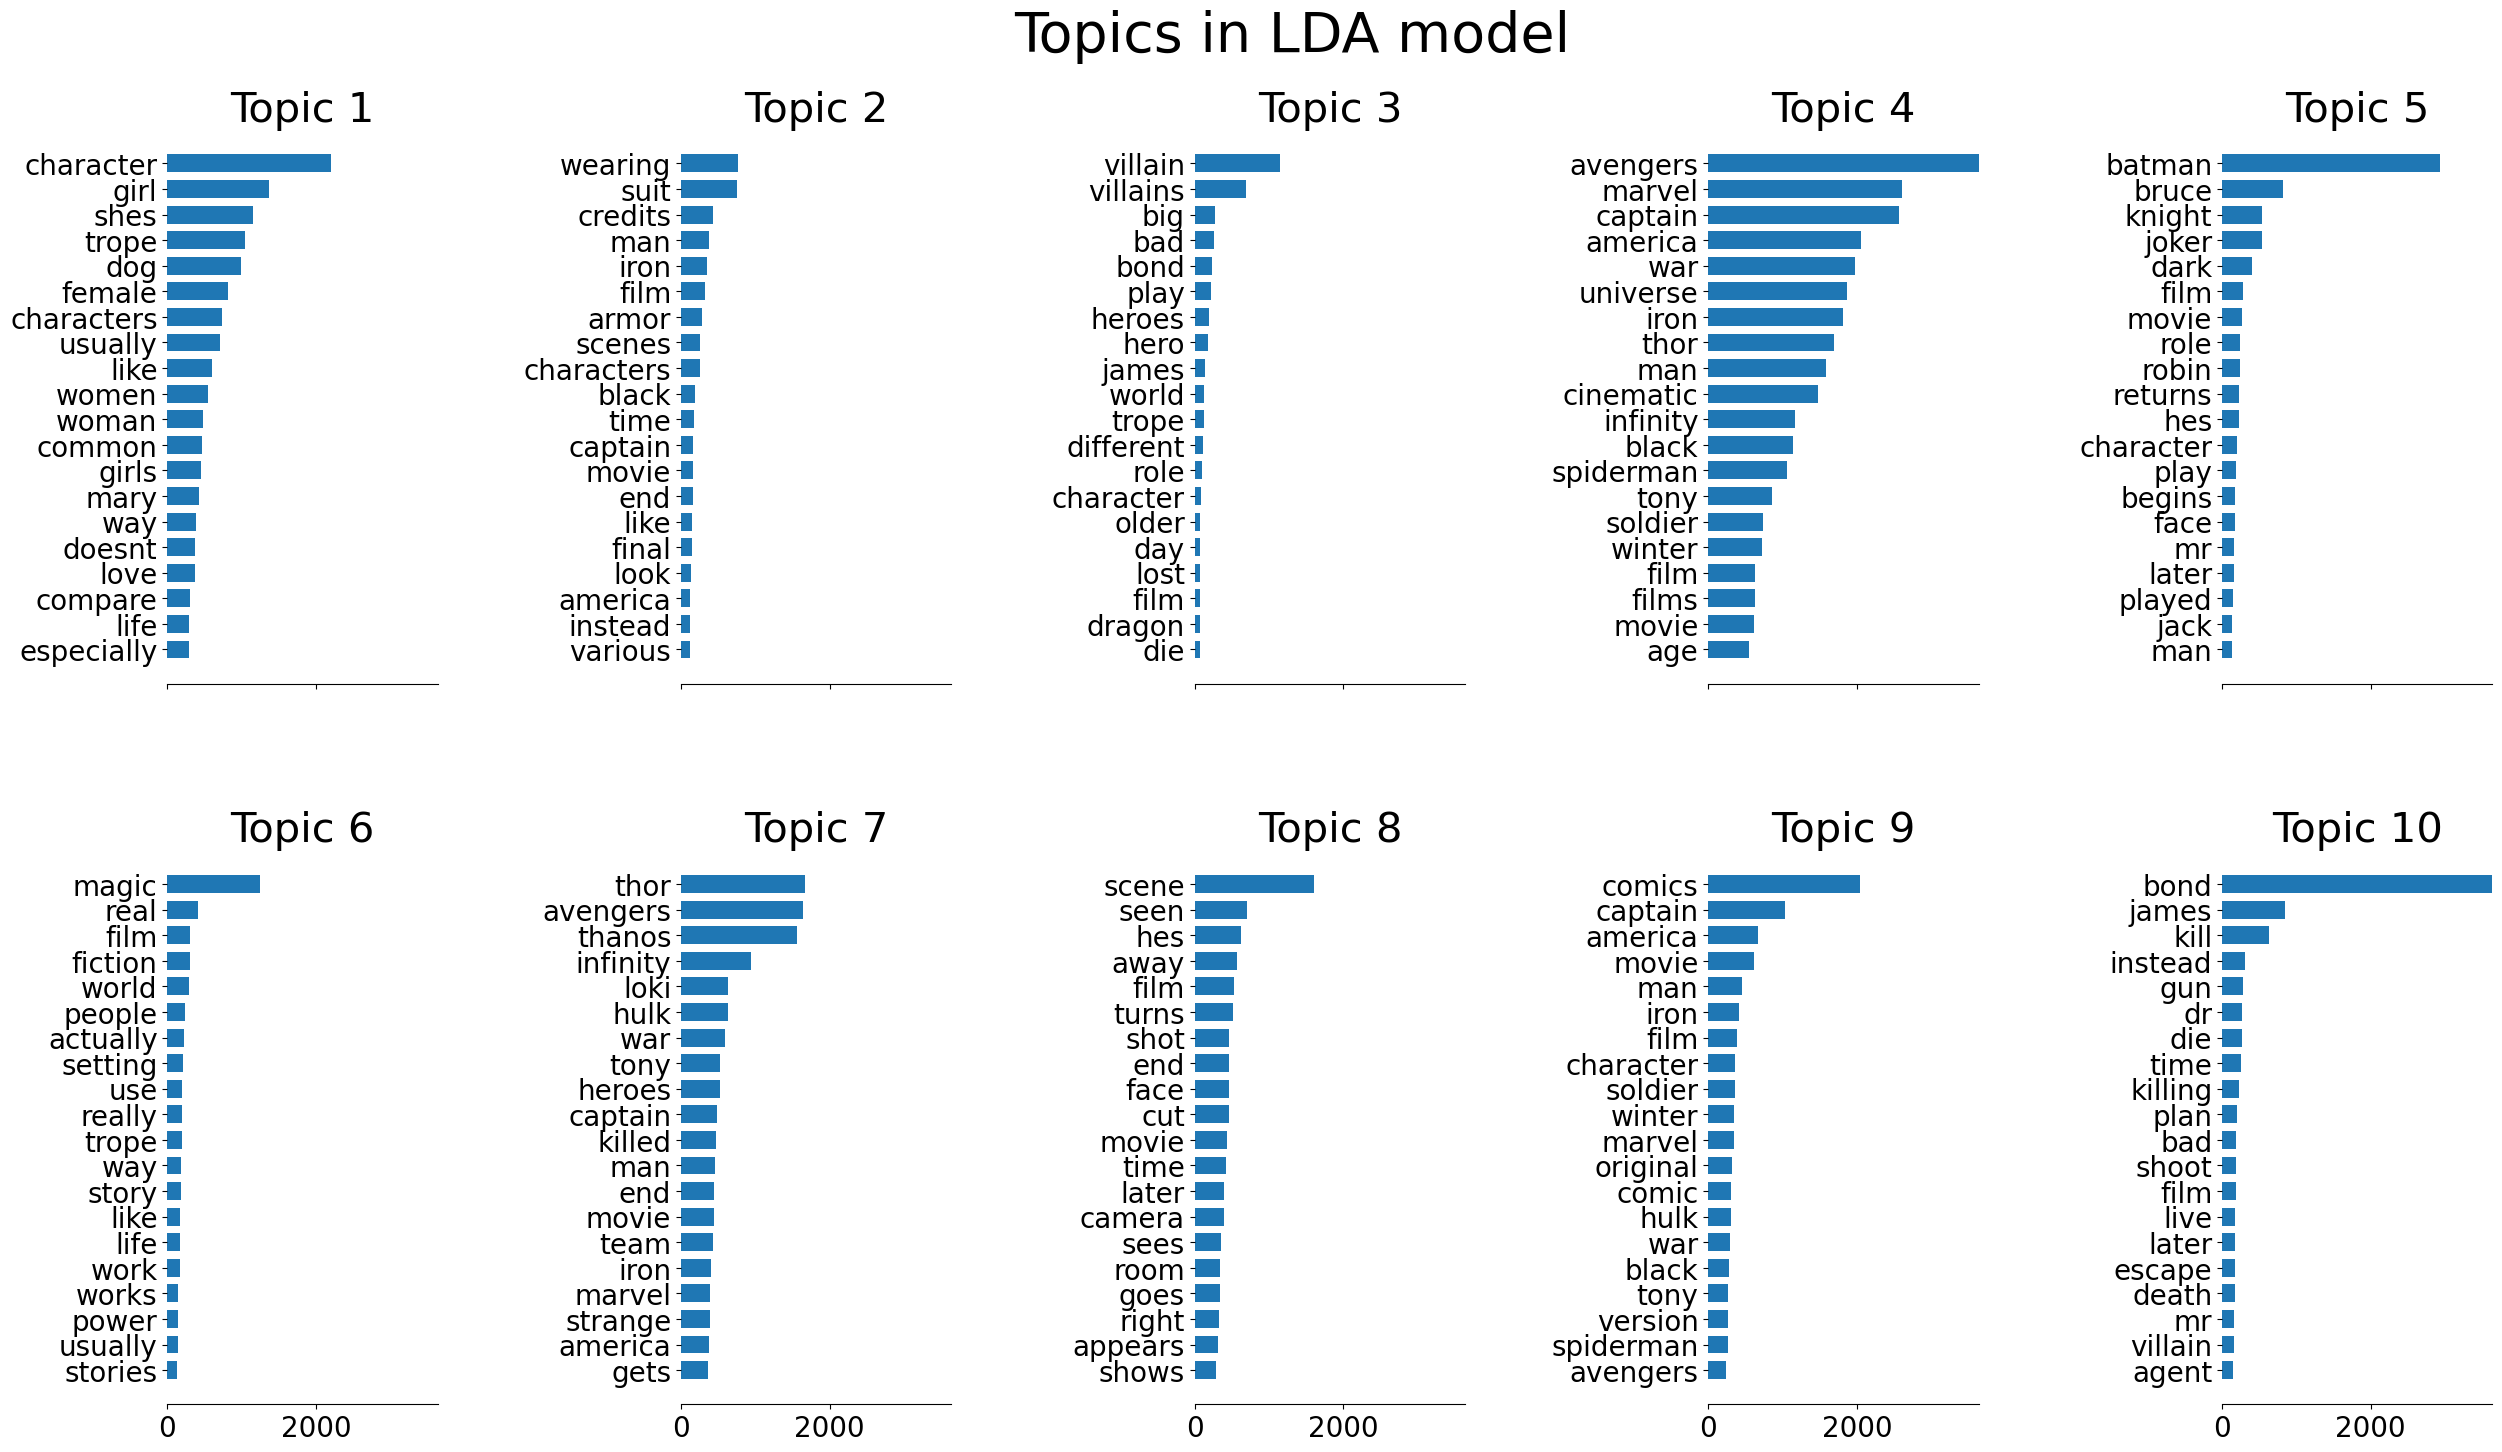

In [12]:

    
def plot_top_words(model, feature_names, n_top_words, title, topics_ids = range(10)):
    # only plots the first 10 topics
    assert(len(topics_ids)<=10) #won't work if there are too many topics to plot
    
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for i, topic_idx in enumerate(topics_ids):
        topic = model.components_[topic_idx]
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[i]
        ax.barh(top_features, weights, 0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        ax.set_xlim([0,max(weights)+0.1])
        fig.suptitle(title, fontsize=40)
        
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")


In [13]:
# now, let's use the trained LDA model to project each trope into the topics 
# based on how much each topic relates to each trope
trope_to_topics= lda.transform(tf)

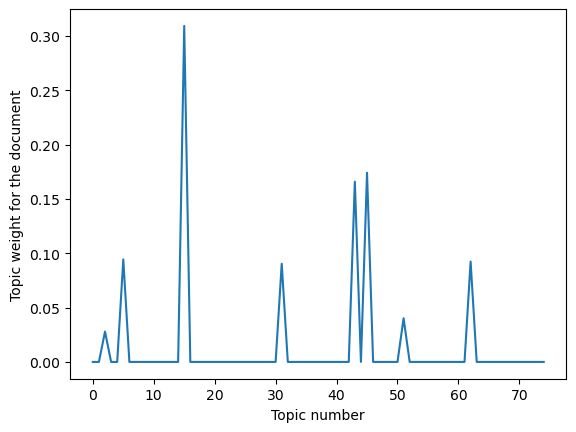

In [14]:
# Let's show an example: let's plot the distribution of the first document across all topics
# The more highly the document depends on a topic, the higher the weight of that document for that topic
# (very high weights will appear as "spikes" in the plot below)
plt.plot(trope_to_topics[0])
plt.xlabel('Topic number')
_= plt.ylabel('Topic weight for the document')


#### Questions: 

1. What seems to be the number corresponding to the most likely topic for this trope? (approximately)
2. How many "relevant" topics are there for this trope?


In [15]:
# so, for each trope we can get the topic that is most highly associated with it (the highest peak in the plot above)
# using python's function "argmax" (= the index at which the maximum number in a list appears)
df['most_probable_topic'] = trope_to_topics.argmax(axis=1)


In [16]:
# now, for each topic we can compute how many of the tropes associated with it lean "male" (gender score <0)
# or "female" (gender score > 0 )
# Finally, we can compute the ratio of the two numbers above
topics_to_gender = []
topic_df['topic_genderedness'] = 1
topic_df['female_leaning'] = pd.NA
topic_df['male_leaning'] = pd.NA

for topic_nb, g in df.groupby('most_probable_topic'):
    nb_male_leaning = (g['gender_score']<0).sum()
    nb_female_leaning = (g['gender_score']>0).sum()
    if (nb_female_leaning==0) & (nb_male_leaning==0):
        r = 1
    else:
        #we add +1 only to avoid a division by 0 
        # (and it's kind of like we are considering 0 a "rounding error", it's not very rigorous though).
        r = (nb_female_leaning+1)/(nb_male_leaning+1) 
    topics_to_gender.append(r) 
    topic_df.loc[topic_nb, 'topic_genderedness'] = r
    topic_df.loc[topic_nb, 'female_leaning'] = nb_female_leaning
    topic_df.loc[topic_nb, 'male_leaning'] = nb_male_leaning



In [17]:
# now, we say that a topic is "female leaning" if a higher proportion of its tropes are "female leaning"
print(f'Number of "female leaning" *topics*: {(topic_df["topic_genderedness"]>1).sum()}')
print(f'Number of "male leaning" *topics*: {(topic_df["topic_genderedness"]<1).sum()}')


Number of "female leaning" *topics*: 28
Number of "male leaning" *topics*: 45


In [18]:
topic_df.sort_values(by= ['topic_genderedness','male_leaning'], ascending= [True,False])

,top_word_0,top_word_1,top_word_2,top_word_3,top_word_4,top_word_5,top_word_6,top_word_7,top_word_8,top_word_9,...,weight_word_13,weight_word_14,weight_word_15,weight_word_16,weight_word_17,weight_word_18,weight_word_19,topic_genderedness,female_leaning,male_leaning
67,sees,title,alien,island,movies,features,attack,movie,final,films,...,667.606046,926.72287,937.871616,1266.111664,1387.148306,1738.89226,4644.574176,0.243902,9,40
55,movie,characters,actually,heroic,end,theyre,doesnt,guy,way,love,...,370.108767,370.444627,488.085817,546.822834,634.821213,745.342704,2219.162702,0.251908,32,130
28,way,world,time,murder,point,hero,villains,good,bad,war,...,248.989751,251.570531,274.625885,303.993261,444.432992,627.153072,659.350506,0.261905,10,41
19,good,city,planet,main,protagonist,life,bad,world,villain,villains,...,141.309382,142.430777,221.393429,314.574637,433.5586,821.897699,848.820092,0.272727,5,21
11,villain,way,usually,death,character,hes,youre,compare,know,end,...,140.102843,141.147569,149.305109,266.464916,276.697562,334.009201,763.841563,0.333333,10,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,dark,daughter,scene,version,form,movie,contrast,eyes,look,film,...,127.663057,132.843542,144.845587,151.325317,304.824713,793.467067,1358.181067,3.200000,15,4
53,way,brother,wife,little,doesnt,like,young,trope,life,kid,...,1389.013156,1402.446416,1407.910863,1516.17074,1628.912067,1690.052449,1963.143383,3.454545,151,43
33,way,family,life,going,shot,story,away,getting,original,home,...,339.500842,455.220365,461.819802,601.970907,627.873011,657.006157,1693.045392,3.600000,35,9
0,especially,life,compare,love,doesnt,way,mary,girls,common,woman,...,732.963365,820.33732,990.455441,1050.721431,1157.590361,1371.727231,2205.813008,5.891892,217,36


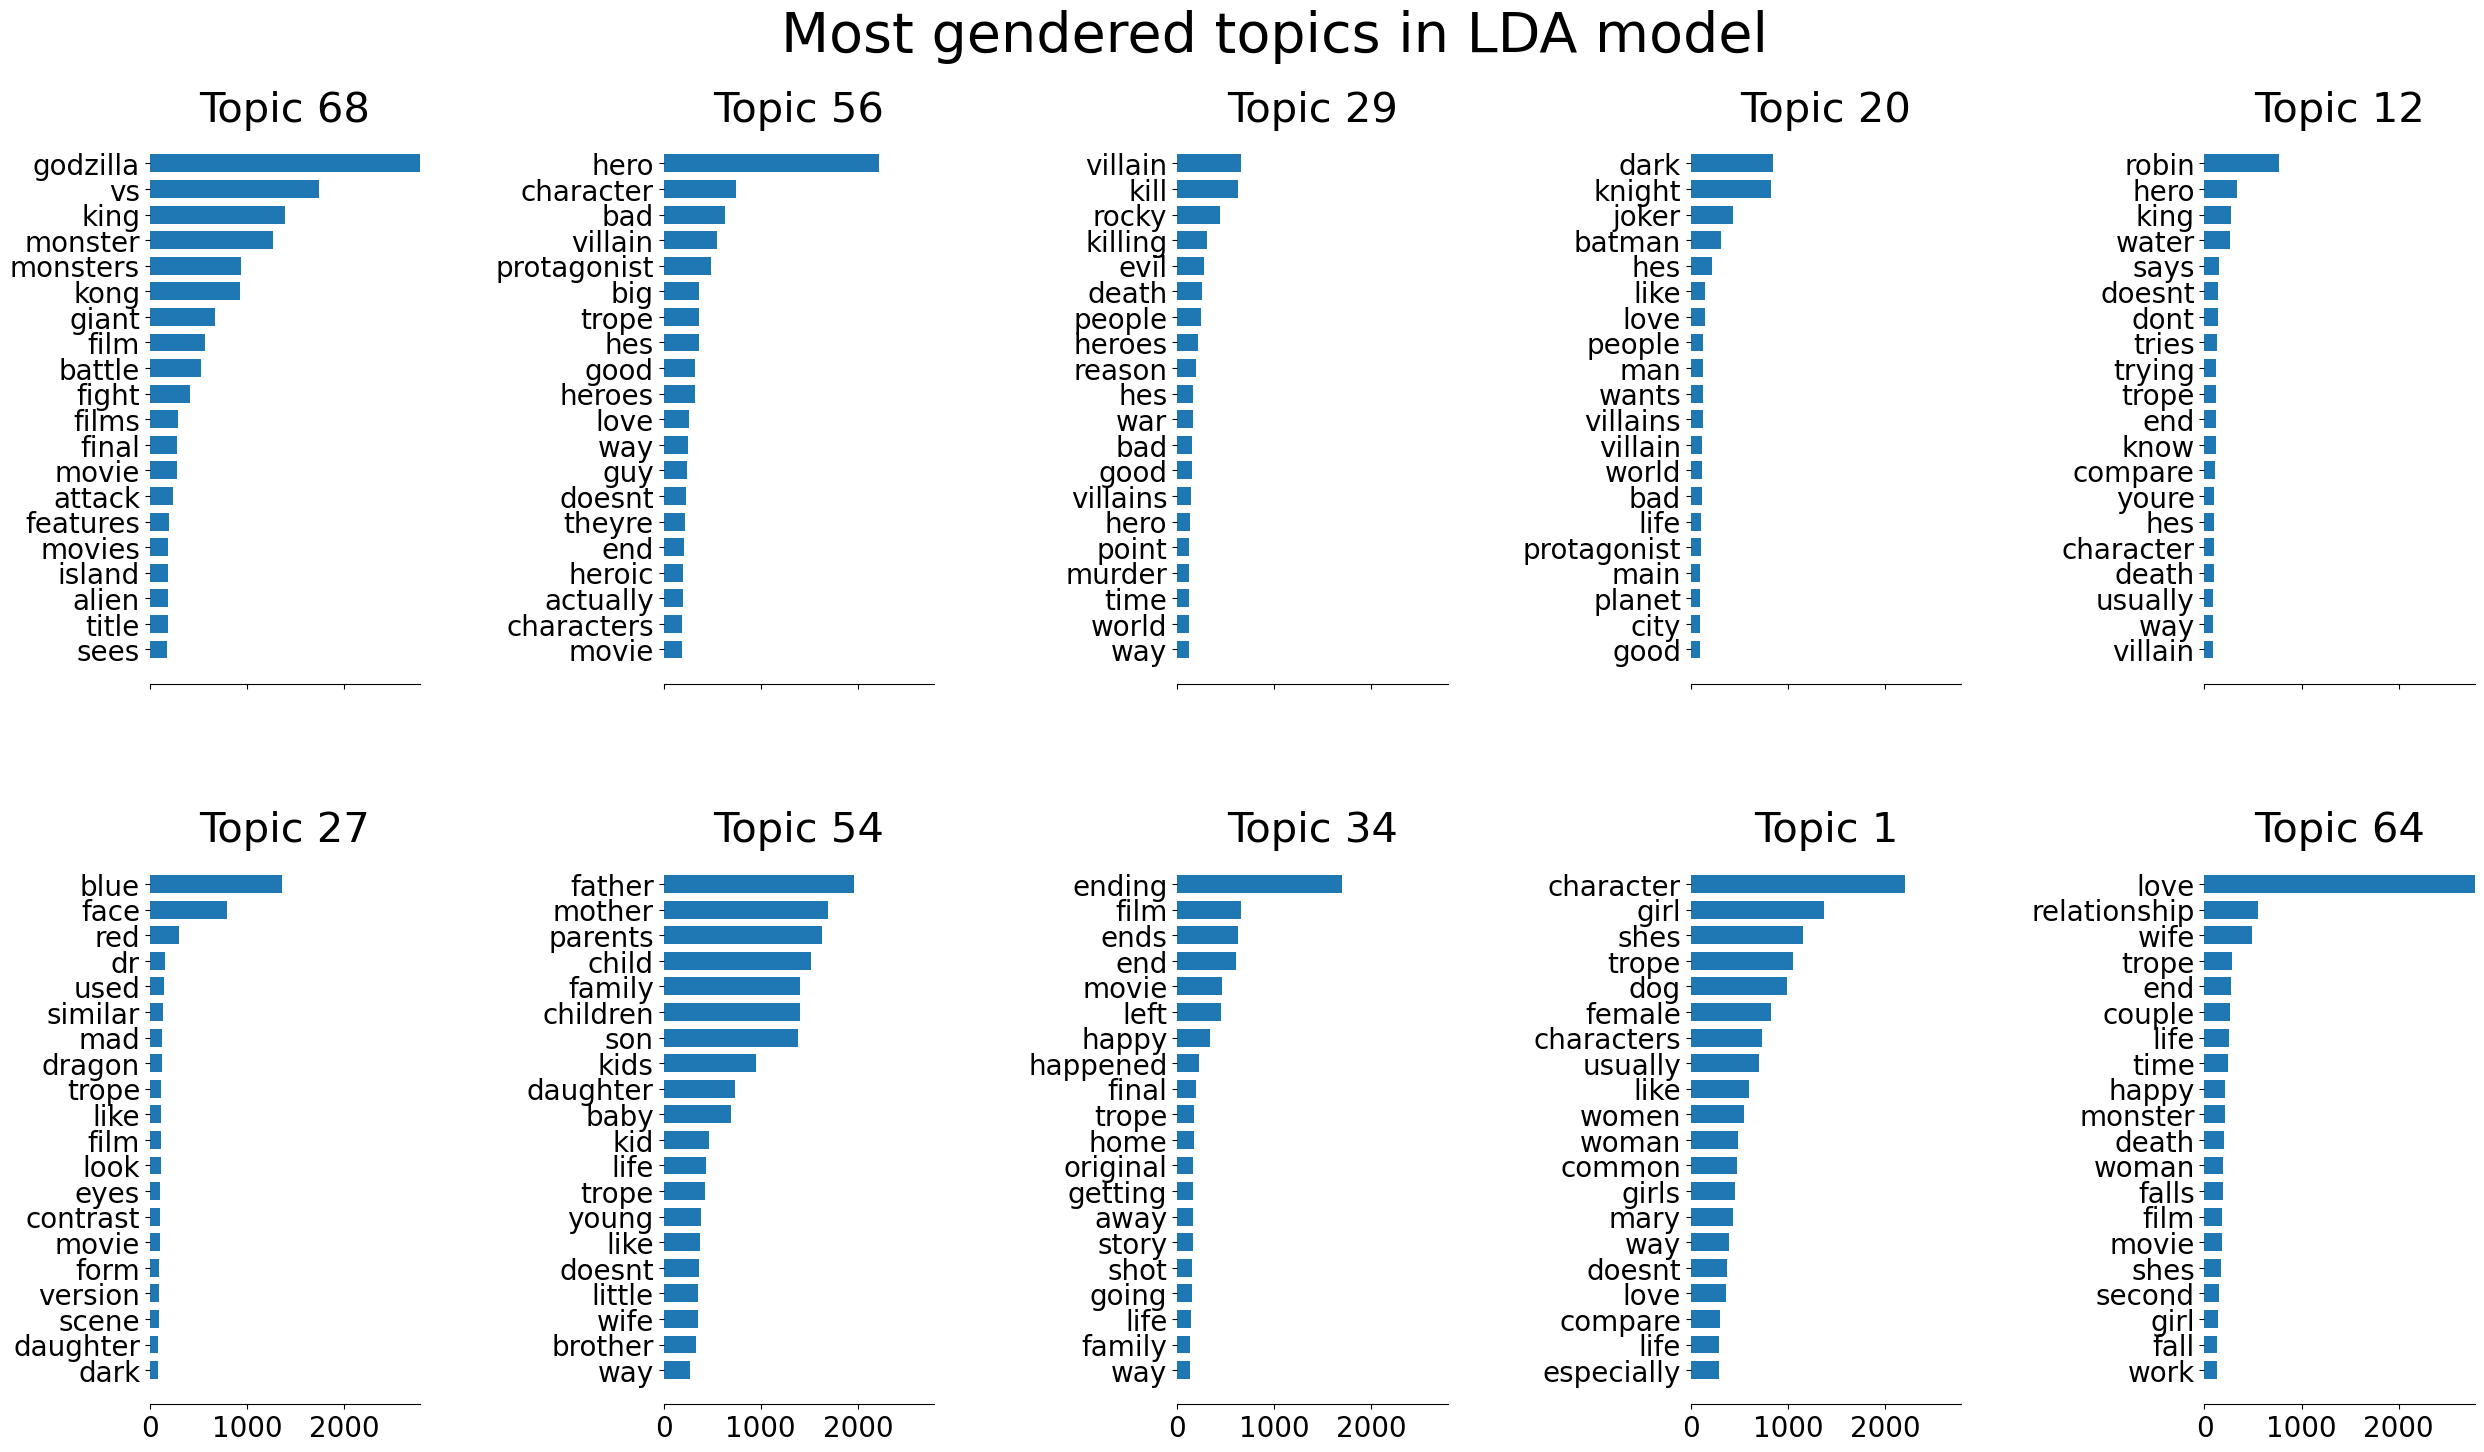

In [19]:
# let's take the top 5 "male" and "female" topics
topics_to_plot = topic_df.sort_values(by= ['topic_genderedness','male_leaning'], 
                                      ascending= [True,False]).index[[0,1,2,3,4,-5,-4,-3,-2,-1]]

plot_top_words(lda, tf_feature_names, n_top_words, "Most gendered topics in LDA model",
              topics_ids= topics_to_plot)

#### Exercise

Try repeating the topic modelling, but this time using:
 - First, only 50 topics.
 - Then, also a maximum of 1000 features for the CountVectorizer (the number of features is equivalent to the size of the vocabulary - the more features we use, the more "words/tokens" we have available for our topics)

Do you notice any difference when changing the parameters? Would you say the results are qualitatively the same or not?


Disclaimer notice for the code adapted from scikit-learn's documentation:

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.